In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests 
import pandas as pd

In [139]:
def get_bs_from_ticker(ticker: str, table: bool=True, plot: bool=True):
    headers = {'User-Agent': "arnavdey02@gmail.com"}

    all_tickers = requests.get(
                                "https://www.sec.gov/files/company_tickers.json",
                                headers=headers
                                )
    company_data = pd.DataFrame.from_dict(all_tickers.json(),
                                     orient='index')
    company_data['cik_str'] = company_data['cik_str'].astype(str).str.zfill(10)
    
    try: 
        my_cik = company_data[company_data['ticker'] == ticker.upper()]['cik_str'].iloc[0]
    except:
        print(f"Ticker {ticker} not found in database.")
        return 
    
    root = f'https://data.sec.gov/api/xbrl/companyconcept/CIK{my_cik}/us-gaap'
    urls = {
        "total_assets": f'{root}/Assets.json',
        "total_liabilities": f'{root}/Liabilities.json',
        "stockholders_equity": f'{root}/StockholdersEquity.json',
        "current_assets": f'{root}/AssetsCurrent.json',
        "current_liabilities": f'{root}/LiabilitiesCurrent.json',
        # "revenues": f'{root}/Revenues.json',
        "net_income_loss": f'{root}/NetIncomeLoss.json'
    }
    
    data = {}
    for metric, url in urls.items():
        response = requests.get(url, headers=headers)
        data[metric] = pd.DataFrame.from_dict(response.json()['units']['USD'])
        
    def process_metric(metric_data, key):
        metric_data = metric_data[metric_data.form == '10-Q']
        metric_data = metric_data.reset_index(drop=True)
        metric_data = metric_data[['end', 'val']]
        metric_data['val'] = metric_data['val'] / 1e0
        metric_data.columns = ["Date",f"{str(key)}"]
        # metric_data.set_index('Date', inplace=True)
        return metric_data
    lengths = []
    for key, value in data.items():
        data[key] = process_metric(value, key)
        lengths.append(data[key].shape[0])
        # data[key] = data[key].reset_index()

    first_key = list(data.keys())[0]
    merged_df = data[first_key].copy()
    # print(merged_df)
    for key in list(data.keys())[1:]:
        df = data[key]
        merged_df = pd.merge(merged_df, df, on='Date', how='outer', suffixes=('', f'_{key}'))
    merged_df = merged_df.set_index('Date')
    merged_df = merged_df.ffill().bfill()
    merged_df = merged_df[~merged_df.index.duplicated(keep='first')]
    
    pd.set_option('display.float_format', '{:.2e}'.format)
    print(f"Balance Sheet Metrics for ticker {ticker}")
    merged_df.sort_index(axis=1, ascending=True)
    if table:
        display(merged_df.head(10) )
    if plot:
        plt.figure(figsize=(10, 8))

        for column in merged_df.columns:
            plt.plot(merged_df.index, merged_df[column], label=column)
        
        # Customize the plot
        plt.title('Financial Metrics Over Time {ticker}')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.xticks(rotation=45)  # Rotate labels if necessary
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))  
        plt.show()

    return merged_df

Ticker zoaksdfjk not found in database.
Balance Sheet Metrics for ticker NVDA


,total_assets,total_liabilities,stockholders_equity,current_assets,current_liabilities,net_income_loss
Date,,,,,,
2008-07-27,3.35e+09,2.81e+09,2.39e+09,2.17e+09,7.79e+08,5.59e+07
2008-10-26,3.35e+09,2.81e+09,2.39e+09,2.17e+09,7.79e+08,1.18e+08
2009-01-25,3.35e+09,2.81e+09,2.39e+09,2.17e+09,7.79e+08,6.17e+07
2009-04-26,3.35e+09,2.81e+09,2.39e+09,2.17e+09,7.79e+08,-2.01e+08
2009-07-26,3.30e+09,2.81e+09,2.25e+09,2.17e+09,8.91e+08,-3.07e+08
2009-10-25,3.46e+09,2.81e+09,2.42e+09,2.36e+09,8.89e+08,-1.99e+08
2010-01-31,3.59e+09,2.81e+09,2.67e+09,2.48e+09,7.84e+08,1.08e+08
2010-05-02,3.80e+09,2.81e+09,2.86e+09,2.73e+09,7.65e+08,1.38e+08
2010-08-01,3.73e+09,2.81e+09,2.76e+09,2.66e+09,8.19e+08,-3.37e+06


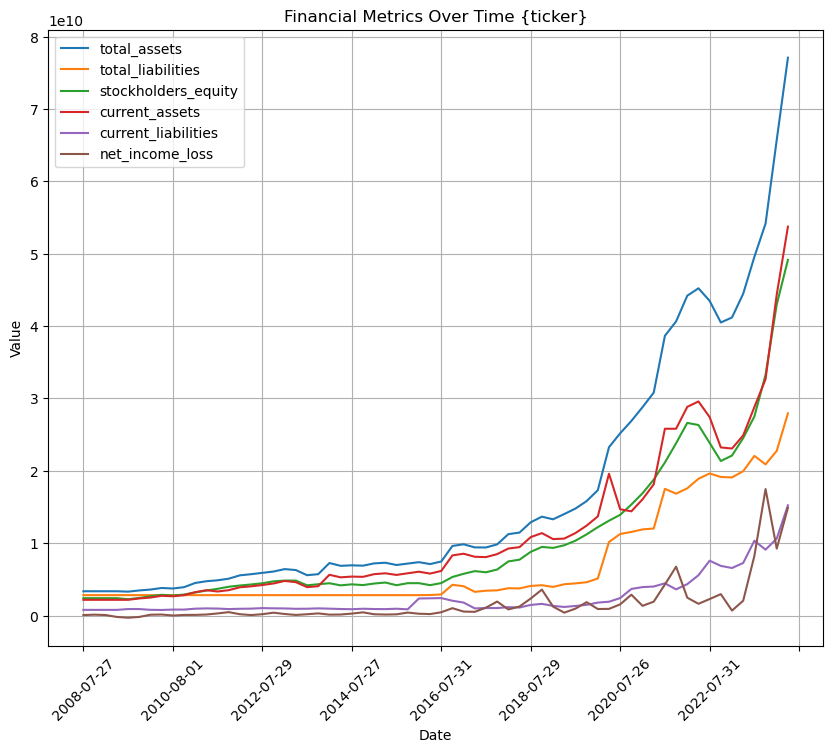

Balance Sheet Metrics for ticker MSFT


,total_assets,total_liabilities,stockholders_equity,current_assets,current_liabilities,net_income_loss
Date,,,,,,
2008-09-30,7.79e+10,3.99e+10,3.36e+10,4.93e+10,2.70e+10,4.37e+09
2008-12-31,7.79e+10,3.99e+10,3.45e+10,4.93e+10,2.70e+10,8.55e+09
2009-03-31,7.79e+10,3.99e+10,3.69e+10,4.93e+10,2.70e+10,1.15e+10
2009-06-30,7.79e+10,3.99e+10,3.96e+10,4.93e+10,2.70e+10,2.98e+09
2009-09-30,8.16e+10,3.99e+10,4.12e+10,5.22e+10,2.88e+10,3.57e+09
2009-12-31,8.21e+10,3.99e+10,4.43e+10,5.25e+10,2.57e+10,1.02e+10
2010-03-31,8.49e+10,3.99e+10,4.57e+10,5.45e+10,2.64e+10,1.42e+10
2010-06-30,8.61e+10,3.99e+10,4.62e+10,5.57e+10,2.61e+10,4.01e+09
2010-09-30,9.15e+10,4.46e+10,4.69e+10,5.96e+10,2.59e+10,5.41e+09


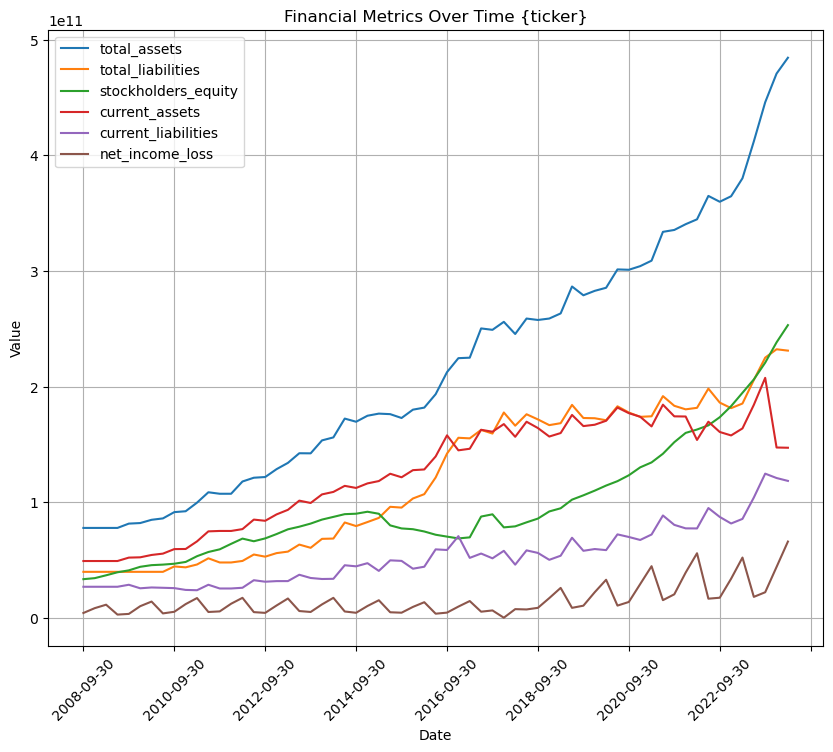

Balance Sheet Metrics for ticker GOOGL


,total_assets,total_liabilities,stockholders_equity,current_assets,current_liabilities,net_income_loss
Date,,,,,,
2014-09-30,1.30e+11,2.71e+10,1.04e+11,8.00e+10,1.68e+10,9.46e+09
2014-12-31,1.30e+11,2.71e+10,1.04e+11,8.00e+10,1.68e+10,2.74e+09
2015-03-31,1.30e+11,2.71e+10,1.04e+11,8.00e+10,1.68e+10,3.52e+09
2015-06-30,1.30e+11,2.71e+10,1.04e+11,8.00e+10,1.68e+10,7.45e+09
2015-09-30,1.44e+11,2.71e+10,1.16e+11,8.81e+10,1.85e+10,1.14e+10
2015-12-31,1.47e+11,2.71e+10,1.20e+11,9.01e+10,1.93e+10,3.98e+09
2016-03-31,1.50e+11,2.62e+10,1.24e+11,9.10e+10,1.77e+10,4.21e+09
2016-06-30,1.54e+11,2.64e+10,1.28e+11,9.42e+10,1.73e+10,9.08e+09
2016-09-30,1.60e+11,2.58e+10,1.34e+11,9.85e+10,1.43e+10,1.41e+10


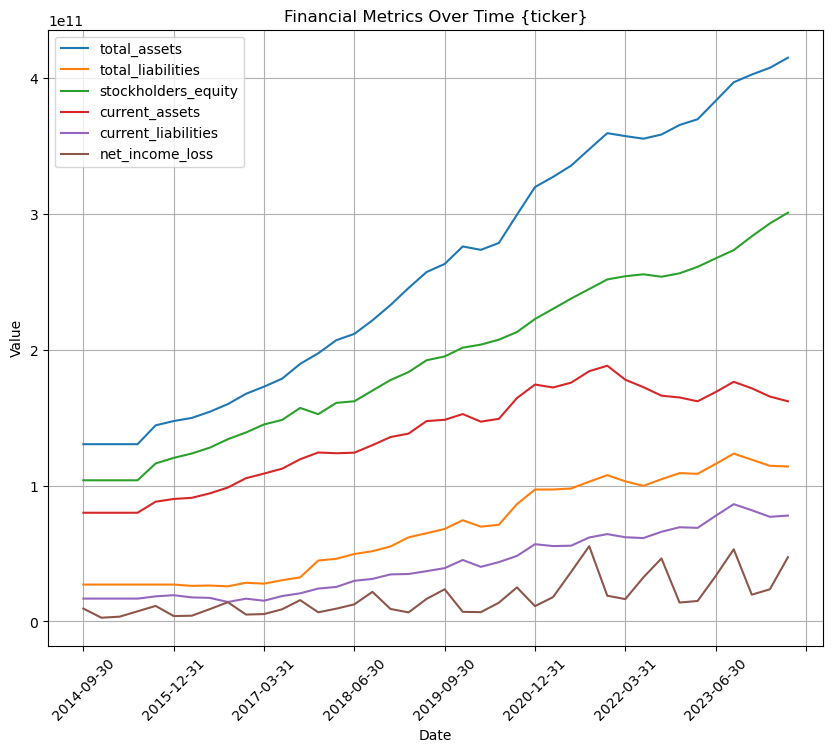

In [140]:
dfs = []
for ticker in ['zoaksdfjk', 'NVDA', 'MSFT', 'GOOGL']:
    dfs.append(get_bs_from_ticker(ticker, plot=True))